In [7]:
# Load necessary libraries
library(mclust) # For Gaussian mixture models and BIC
library(MCMCpack) # For MCMC

# Set the random seed
set.seed(781209)

# Load the galaxies dataset (assuming it's part of the mclust library)
data(galaxies)
galaxy_data <- galaxies

In [8]:
galaxy_data


[1]  9172  9350  9483  9558  9775 10227 10406 16084 16170 18419 18552 18600
[13] 18927 19052 19070 19330 19343 19349 19440 19473 19529 19541 19547 19663
[25] 19846 19856 19863 19914 19918 19973 19989 20166 20175 20179 20196 20215
[37] 20221 20415 20629 20795 20821 20846 20875 20986 21137 21492 21701 21814
[49] 21921 21960 22185 22209 22242 22249 22314 22374 22495 22746 22747 22888
[61] 22914 23206 23241 23263 23484 23538 23542 23666 23706 23711 24129 24285
[73] 24289 24366 24717 24990 25633 26690 26995 32065 32789 34279

[1] 1.496393

[1] "s = 500"
[1] "s = 1000"
[1] "s = 1500"
[1] "s = 2000"
[1] "s = 2500"
[1] "s = 3000"
[1] "s = 3500"
[1] "s = 4000"
[1] "s = 4500"
[1] "s = 5000"
[1] "s = 5500"
[1] "s = 6000"
[1] "s = 6500"
[1] "s = 7000"
[1] "s = 7500"
[1] "s = 8000"
[1] "s = 8500"
[1] "s = 9000"
[1] "s = 9500"
[1] "s = 10000"
[1] "s = 10500"
[1] "s = 11000"
[1] "s = 11500"
[1] "s = 12000"
[1] "s = 12500"
[1] "s = 13000"
[1] "s = 13500"
[1] "s = 14000"
[1] "s = 14500"
[1] "s = 15000"
[1] "s = 15500"
[1] "s = 16000"
[1] "s = 16500"
[1] "s = 17000"
[1] "s = 17500"
[1] "s = 18000"
[1] "s = 18500"
[1] "s = 19000"
[1] "s = 19500"
[1] "s = 20000"
[1] "s = 20500"
[1] "s = 21000"
[1] "s = 21500"
[1] "s = 22000"
[1] "s = 22500"
[1] "s = 23000"
[1] "s = 23500"
[1] "s = 24000"
[1] "s = 24500"
[1] "s = 25000"


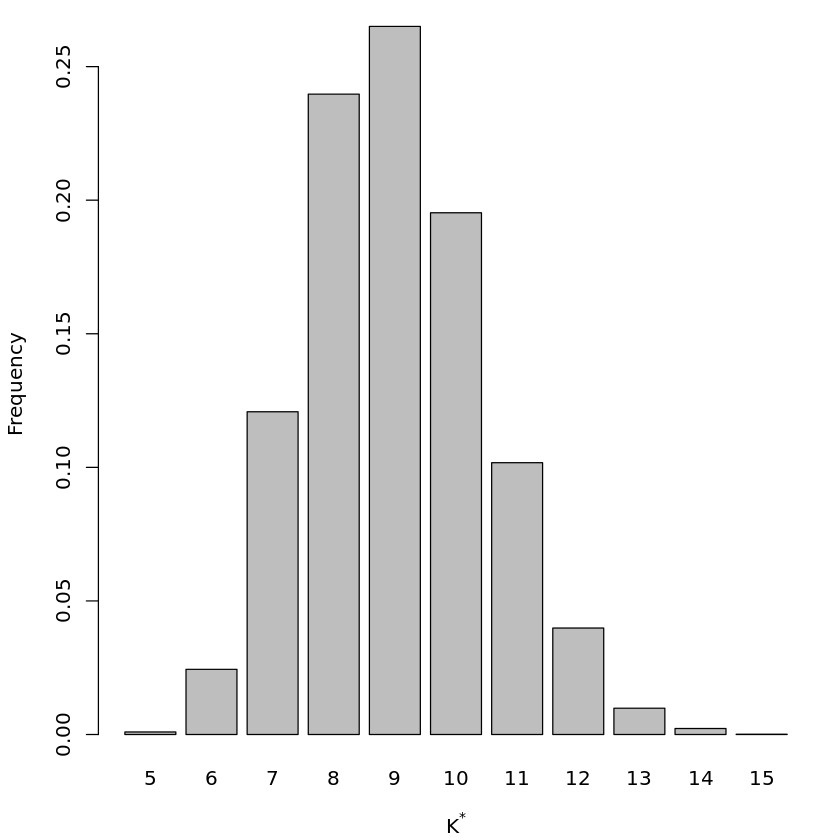

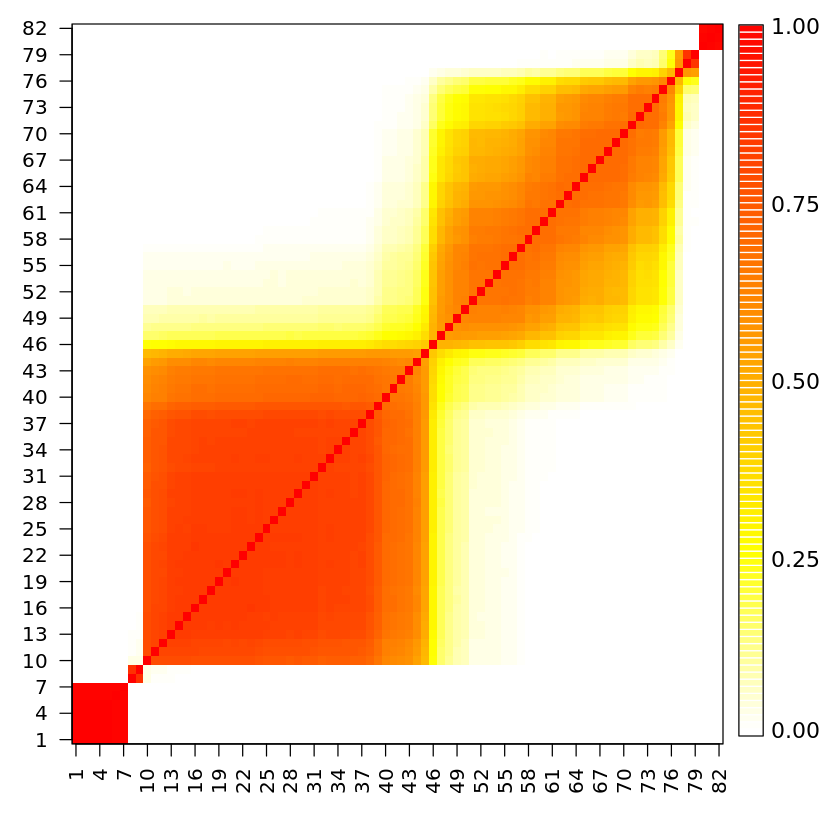

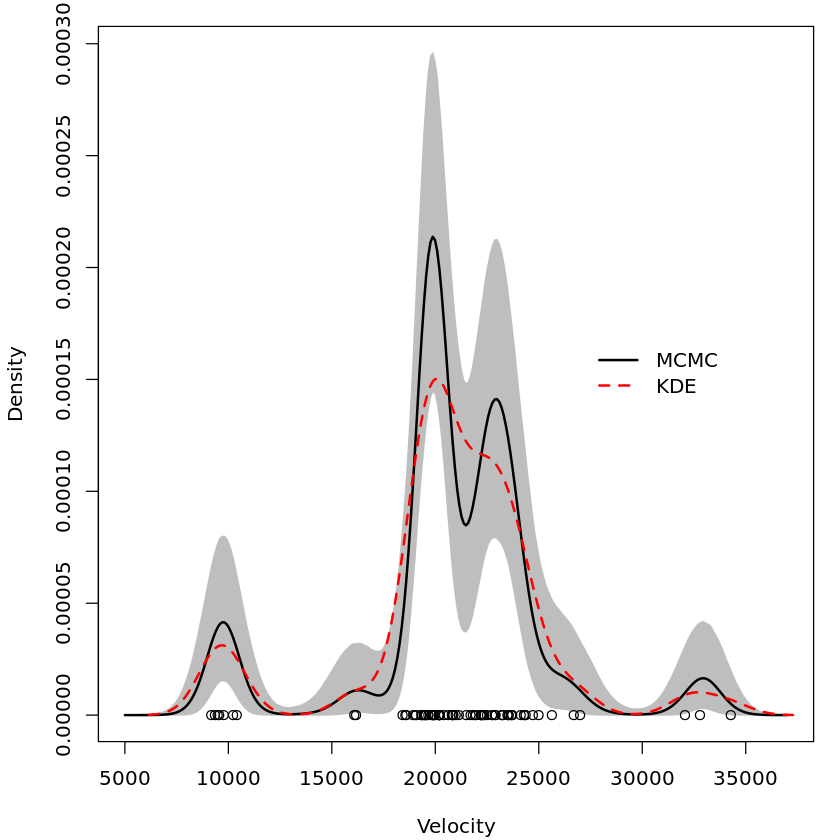

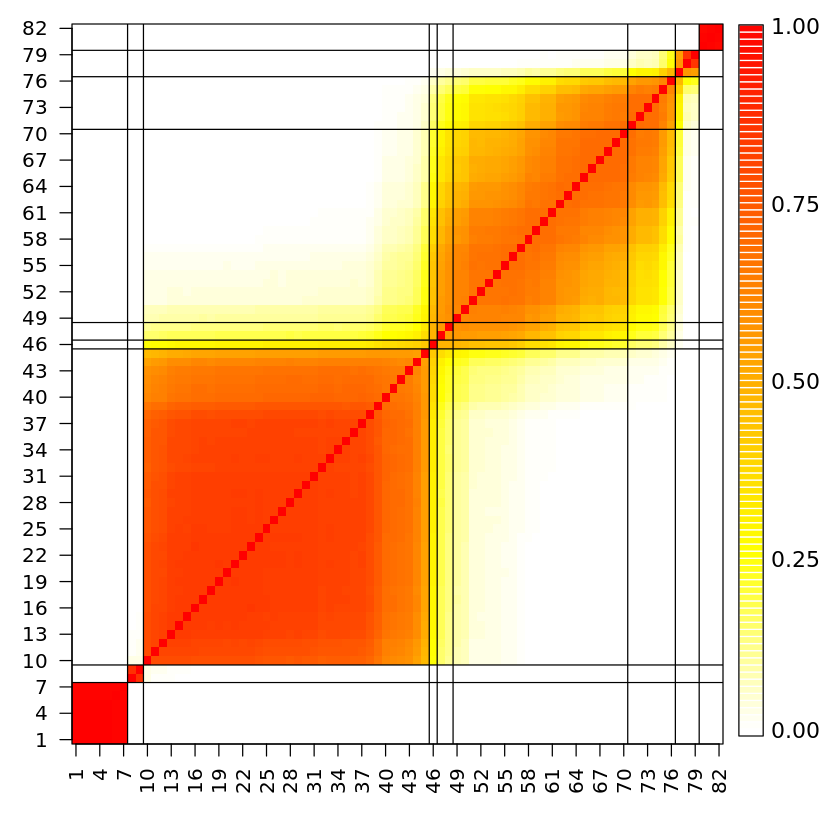

In [21]:
## Full Bayesian estimation of a mixture model for density estimation in the galaxies dataset
rm(list=ls())

### Loading data and setting up global variables
library(MASS)
library(MCMCpack)
data(galaxies)
x  = galaxies
n  = length(x)
set.seed(781209)

### Fitting a Bayesian mixture model with 
KK = 30   ## In this formulation, it should be interpreted as the 
          ## maximum number of components allowed

## Finding the value of alpha consistent with 6 expected components a priori
ff = function(alpha)  alpha*log((82+alpha-1)/alpha) - 6
alph = uniroot(ff, c(0.01, 20))
alph$root  # 1.496393

## Priors set up using an "empirical Bayes" approach
aa  = rep(1.5/KK,KK)  # We approximate 1.496393 by 1.5
eta = mean(x)    
tau = sqrt(var(x))
dd  = 2
qq  = var(x)/KK

## Initialize the parameters
w     = rep(1,KK)/KK
mu    = rnorm(KK, mean(x), sd(x))
sigma = sd(x)/KK
cc    = sample(1:KK, n, replace=T, prob=w)

## Number of iterations of the sampler
rrr   = 25000
burn  = 5000

## Storing the samples
cc.out    = array(0, dim=c(rrr, n))
w.out     = array(0, dim=c(rrr, KK))
mu.out    = array(0, dim=c(rrr, KK))
sigma.out = array(0, dim=c(rrr, KK))
logpost   = rep(0, rrr)


for(s in 1:rrr){
  # Sample the indicators
  for(i in 1:n){
    v = rep(0,KK)
    for(k in 1:KK){
      v[k] = log(w[k]) + dnorm(x[i], mu[k], sigma, log=TRUE)  #Compute the log of the weights
    }
    v = exp(v - max(v))/sum(exp(v - max(v)))
    cc[i] = sample(1:KK, 1, replace=TRUE, prob=v)
  }
  
  # Sample the weights
  w = as.vector(rdirichlet(1, aa + tabulate(cc, nbins=KK)))
  
  # Sample the means
  for(k in 1:KK){
    nk    = sum(cc==k)
    xsumk = sum(x[cc==k])
    tau2.hat = 1/(nk/sigma^2 + 1/tau^2)
    mu.hat  = tau2.hat*(xsumk/sigma^2 + eta/tau^2)
    mu[k]   = rnorm(1, mu.hat, sqrt(tau2.hat))
  }
  
  # Sample the variances
  dd.star = dd + n/2
  qq.star = qq + sum((x - mu[cc])^2)/2
  sigma = sqrt(1/rgamma(1, dd.star, qq.star))
  
  # Store samples
  cc.out[s,]   = cc
  w.out[s,]    = w
  mu.out[s,]   = mu
  sigma.out[s] = sigma
  for(i in 1:n){
    logpost[s] = logpost[s] + log(w[cc[i]]) + dnorm(x[i], mu[cc[i]], sigma, log=TRUE)
  }
  logpost[s] = logpost[s] + log(ddirichlet(w, aa))
  for(k in 1:KK){
      logpost[s] = logpost[s] + dnorm(mu[k], eta, tau, log=TRUE)
  }
  logpost[s] = logpost[s] + dgamma(1/sigma^2, dd, qq, log=TRUE) - 4*log(sigma)
  if(s/500==floor(s/500)){
    print(paste("s =",s))
  }
}

nunique = function(x)   length(unique(x))
Kstar = apply(cc.out[-seq(1,burn),],1,nunique)
par(mar=c(4,4,1,1) + 0.1)
barplot(table(Kstar)/sum(table(Kstar)), xlab=expression(K^"*"), ylab="Frequency")
#dev.print(file="postKstaralpha2.pdf", dev=pdf)


## Construct pairwise co-clustering matrix for this dataset
pairwise = matrix(0, nrow=n, ncol=n)
for(s in 1:(rrr-burn)){
  for(i in 1:n){
    for(j in i:n){
      pairwise[i,j] = pairwise[i,j] + as.numeric(cc.out[s+burn,i]==cc.out[s+burn,j])
      pairwise[j,i] = pairwise[i,j]
    }
  }  
}
DD = pairwise/max(pairwise)

heatmapplot = function(DD, alab, subsetaxis, llc=FALSE){
  n = dim(DD)[1]
  #colorscale = rev(gray(0:100 / 100))
  colorscale = c("white", rev(heat.colors(100)))
  nf = layout(matrix(c(1,2),nrow=1,ncol=2), c(7,1), TRUE)
  par(mar=c(4,3,1,0.5))
  
  ###Display heat-map
  image(seq(1,n), seq(1,n), DD, axes=F, xlab="", ylab="", 
        col=colorscale[seq(floor(min(100*DD)), floor(max(100*DD))) + 1])
  axis(1,at=subsetaxis,labels=alab[subsetaxis],las=2,cex.axis=1)
  axis(2,at=subsetaxis,labels=alab[subsetaxis],las=2,cex.axis=1)
  box()
  abline(v = llc+0.5)
  abline(h = llc+0.5)
  
  ###Display color scale
  par(mar=c(3,0,0,0))
  plot(1:100,1:100,xlim=c(0,2),ylim=c(0,100),type="n",axes=F,xlab ="",ylab ="")
  yposr = 1:100
  rect(0, yposr-.5, 0.5, yposr+.5,col = colorscale, border=F)
  rect(0, .5, 0.5, 100.5,col = "transparent")
  text(0.42,c(yposr[1],yposr[25],yposr[50],yposr[75],yposr[100]),c("0.00","0.25","0.50","0.75","1.00"),pos=4,cex=1.1)
}
heatmapplot(DD, seq(1,n), seq(1,n,by=3))


## Plot Bayesian estimate with pointwise credible bands along with kernel density estimate and frequentist point estimate
## Compute the samples of the density over a dense grid
xx  = seq(5000,37000,length=300)
density.mcmc = array(0, dim=c(rrr-burn,length(xx)))
for(s in 1:(rrr-burn)){
  for(k in 1:KK){
    density.mcmc[s,] = density.mcmc[s,] + w.out[s+burn,k]*dnorm(xx,mu.out[s+burn,k],sigma.out[s+burn])
  }
}
density.mcmc.m = apply(density.mcmc , 2, mean)

yy = density(x)
colscale = c("black", "red")
density.mcmc.lq = apply(density.mcmc, 2, quantile, 0.025)
density.mcmc.uq = apply(density.mcmc, 2, quantile, 0.975)
par(mfrow=c(1,1))
par(mar=c(4,4,1,1)+0.1)
plot(xx, density.mcmc.m, type="n",ylim=c(0,max(density.mcmc.uq)),xlab="Velocity", ylab="Density")
polygon(c(xx,rev(xx)), c(density.mcmc.lq, rev(density.mcmc.uq)), col="grey", border="grey")
lines(xx, density.mcmc.m, col=colscale[1], lwd=2)
lines(yy, col=colscale[2], lty=2, lwd=2)
points(x, rep(0,n))
legend(27000, 0.00017, c("MCMC","KDE"), col=colscale[c(1,2)], lty=c(1,2), lwd=2, bty="n")


##### Finding optimal partition according to Binder's loss function
##
## Function that computes the loss at a particular configuration
Lstst = function(cch, DD, Dbar){
  z = 0
  for(i in 1:(n-1)){
    for(j in (i+1):n){
      if(cch[i]==cch[j]){
        z = z + (DD[i,j]-Dbar)
      }
    }
  }
  return(z)
}

## Initial value of the algorithm is the last iteration of the sampler
## Using as.numeric(factor()) is a cheap way to force the cluster labels 
## to be sequential starting at 1
cch = as.numeric(factor(cc))

## Setup parameters for the recursive alorithm
Dbar = 0.50
optLstst.old  = -Inf
optLstst.new = Lstst(cch, DD, Dbar=Dbar)
maxiter = 50
niter   = 1
while((optLstst.old!=optLstst.new)&(niter<=maxiter)){
  for(i in 1:n){
    nq   = max(cch) + 1
    q    = rep(0, nq)
    for(s in 1:nq){
      ccht    = cch
      ccht[i] = s
      q[s] = Lstst(ccht, DD, Dbar=Dbar)
    }
    cch[i] = which.max(q)
    cch = as.numeric(factor(cch))
  }
  optLstst.old = optLstst.new
  optLstst.new = Lstst(cch, DD, Dbar=Dbar)
  niter = niter+1
}
#print(nunique(cch))

## Create another heatmap plot of the co-clustering matrix in which the 
## optimal clusters are represented.
cchlo    = as.numeric(as.character(factor(cch, labels=order(unique(cch)))))
cchlotab = table(cchlo)
llc      = cumsum(cchlotab[-length(cchlotab)])
heatmapplot(DD, seq(1,n), seq(1,n,by=3), llc=llc)
#dev.print(file="galaxiesheatmap50.pdf", dev=pdf)


[1] 1.496393

[1] "s = 500"
[1] "s = 1000"
[1] "s = 1500"
[1] "s = 2000"
[1] "s = 2500"
[1] "s = 3000"
[1] "s = 3500"
[1] "s = 4000"
[1] "s = 4500"
[1] "s = 5000"
[1] "s = 5500"
[1] "s = 6000"
[1] "s = 6500"
[1] "s = 7000"
[1] "s = 7500"
[1] "s = 8000"
[1] "s = 8500"
[1] "s = 9000"
[1] "s = 9500"
[1] "s = 10000"
[1] "s = 10500"
[1] "s = 11000"
[1] "s = 11500"
[1] "s = 12000"
[1] "s = 12500"
[1] "s = 13000"
[1] "s = 13500"
[1] "s = 14000"
[1] "s = 14500"
[1] "s = 15000"
[1] "s = 15500"
[1] "s = 16000"
[1] "s = 16500"
[1] "s = 17000"
[1] "s = 17500"
[1] "s = 18000"
[1] "s = 18500"
[1] "s = 19000"
[1] "s = 19500"
[1] "s = 20000"
[1] "s = 20500"
[1] "s = 21000"
[1] "s = 21500"
[1] "s = 22000"
[1] "s = 22500"
[1] "s = 23000"
[1] "s = 23500"
[1] "s = 24000"
[1] "s = 24500"
[1] "s = 25000"


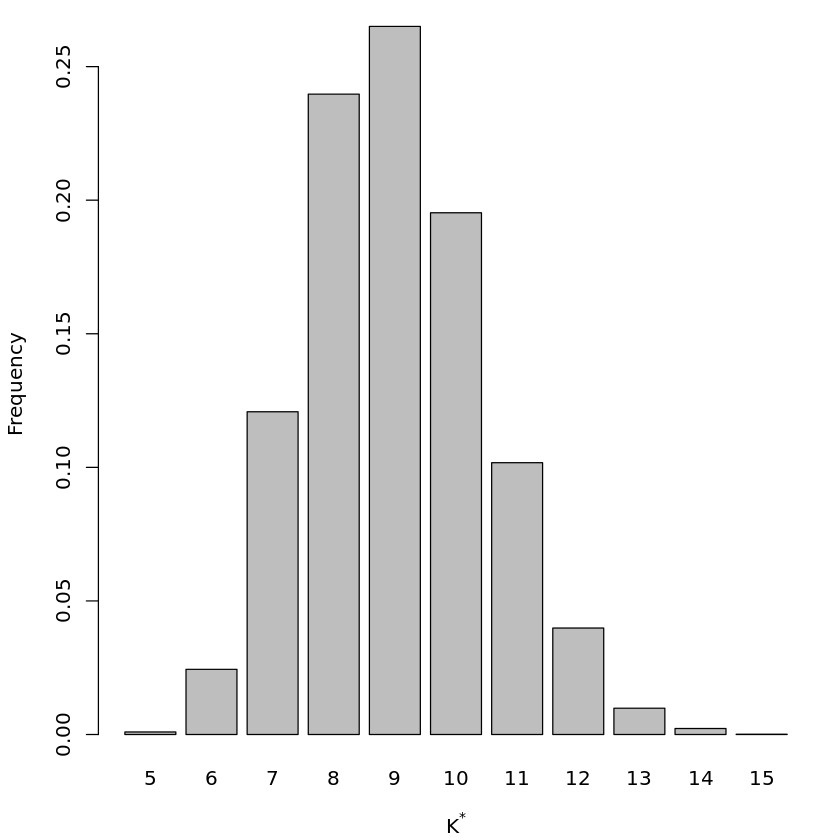

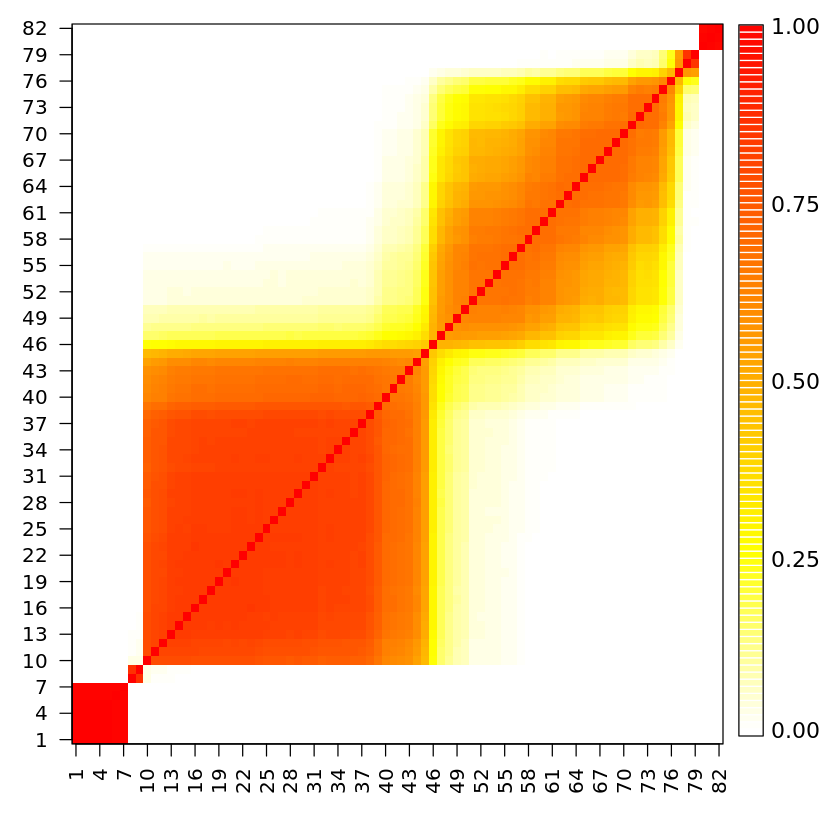

[1] 9


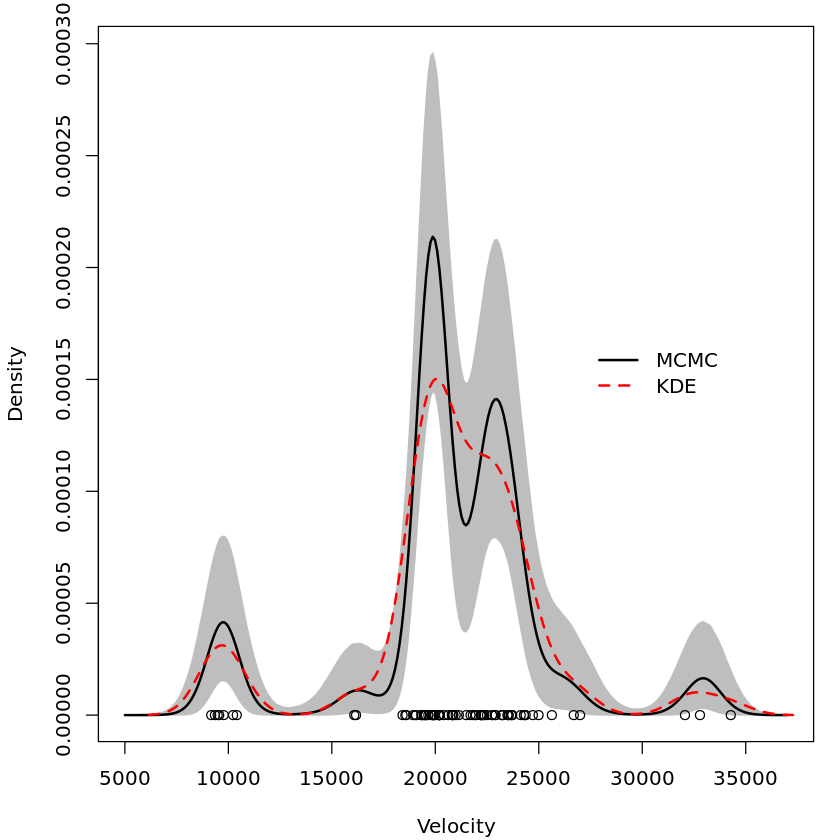

In [22]:
## Full Bayesian estimation of a mixture model for density estimation in the galaxies dataset
rm(list=ls())

### Loading data and setting up global variables
library(MASS)
library(MCMCpack)
data(galaxies)
x  = galaxies
n  = length(x)
set.seed(781209)

### Fitting a Bayesian mixture model with 
KK = 30   ## In this formulation, it should be interpreted as the 
          ## maximum number of components allowed

## Finding the value of alpha consistent with 6 expected components a priori
ff = function(alpha)  alpha*log((82+alpha-1)/alpha) - 6
alph = uniroot(ff, c(0.01, 20))
alph$root  # 1.496393

## Priors set up using an "empirical Bayes" approach
aa  = rep(1.5/KK,KK)  # We approximate 1.496393 by 1.5
eta = mean(x)    
tau = sqrt(var(x))
dd  = 2
qq  = var(x)/KK

## Initialize the parameters
w     = rep(1,KK)/KK
mu    = rnorm(KK, mean(x), sd(x))
sigma = sd(x)/KK
cc    = sample(1:KK, n, replace=T, prob=w)

## Number of iterations of the sampler
rrr   = 25000
burn  = 5000

## Storing the samples
cc.out    = array(0, dim=c(rrr, n))
w.out     = array(0, dim=c(rrr, KK))
mu.out    = array(0, dim=c(rrr, KK))
sigma.out = array(0, dim=c(rrr, KK))
logpost   = rep(0, rrr)

for(s in 1:rrr){
  # Sample the indicators
  for(i in 1:n){
    v = rep(0,KK)
    for(k in 1:KK){
      v[k] = log(w[k]) + dnorm(x[i], mu[k], sigma, log=TRUE)  #Compute the log of the weights
    }
    v = exp(v - max(v))/sum(exp(v - max(v)))
    cc[i] = sample(1:KK, 1, replace=TRUE, prob=v)
  }
  
  # Sample the weights
  w = as.vector(rdirichlet(1, aa + tabulate(cc, nbins=KK)))
  
  # Sample the means
  for(k in 1:KK){
    nk    = sum(cc==k)
    xsumk = sum(x[cc==k])
    tau2.hat = 1/(nk/sigma^2 + 1/tau^2)
    mu.hat  = tau2.hat*(xsumk/sigma^2 + eta/tau^2)
    mu[k]   = rnorm(1, mu.hat, sqrt(tau2.hat))
  }
  
  # Sample the variances
  dd.star = dd + n/2
  qq.star = qq + sum((x - mu[cc])^2)/2
  sigma = sqrt(1/rgamma(1, dd.star, qq.star))
  
  # Store samples
  cc.out[s,]   = cc
  w.out[s,]    = w
  mu.out[s,]   = mu
  sigma.out[s] = sigma
  for(i in 1:n){
    logpost[s] = logpost[s] + log(w[cc[i]]) + dnorm(x[i], mu[cc[i]], sigma, log=TRUE)
  }
  logpost[s] = logpost[s] + log(ddirichlet(w, aa))
  for(k in 1:KK){
      logpost[s] = logpost[s] + dnorm(mu[k], eta, tau, log=TRUE)
  }
  logpost[s] = logpost[s] + dgamma(1/sigma^2, dd, qq, log=TRUE) - 4*log(sigma)
  if(s/500==floor(s/500)){
    print(paste("s =",s))
  }
}

nunique = function(x)   length(unique(x))
Kstar = apply(cc.out[-seq(1,burn),],1,nunique)
par(mar=c(4,4,1,1) + 0.1)
barplot(table(Kstar)/sum(table(Kstar)), xlab=expression(K^"*"), ylab="Frequency")
#dev.print(file="postKstaralpha2.pdf", dev=pdf)


## Construct pairwise co-clustering matrix for this dataset
pairwise = matrix(0, nrow=n, ncol=n)
for(s in 1:(rrr-burn)){
  for(i in 1:n){
    for(j in i:n){
      pairwise[i,j] = pairwise[i,j] + as.numeric(cc.out[s+burn,i]==cc.out[s+burn,j])
      pairwise[j,i] = pairwise[i,j]
    }
  }  
}
DD = pairwise/max(pairwise)

heatmapplot = function(DD, alab, subsetaxis, llc=FALSE){
  n = dim(DD)[1]
  #colorscale = rev(gray(0:100 / 100))
  colorscale = c("white", rev(heat.colors(100)))
  nf = layout(matrix(c(1,2),nrow=1,ncol=2), c(7,1), TRUE)
  par(mar=c(4,3,1,0.5))
  
  ###Display heat-map
  image(seq(1,n), seq(1,n), DD, axes=F, xlab="", ylab="", 
        col=colorscale[seq(floor(min(100*DD)), floor(max(100*DD))) + 1])
  axis(1,at=subsetaxis,labels=alab[subsetaxis],las=2,cex.axis=1)
  axis(2,at=subsetaxis,labels=alab[subsetaxis],las=2,cex.axis=1)
  box()
  abline(v = llc+0.5)
  abline(h = llc+0.5)
  
  ###Display color scale
  par(mar=c(3,0,0,0))
  plot(1:100,1:100,xlim=c(0,2),ylim=c(0,100),type="n",axes=F,xlab ="",ylab ="")
  yposr = 1:100
  rect(0, yposr-.5, 0.5, yposr+.5,col = colorscale, border=F)
  rect(0, .5, 0.5, 100.5,col = "transparent")
  text(0.42,c(yposr[1],yposr[25],yposr[50],yposr[75],yposr[100]),c("0.00","0.25","0.50","0.75","1.00"),pos=4,cex=1.1)
}
heatmapplot(DD, seq(1,n), seq(1,n,by=3))


## Plot Bayesian estimate with pointwise credible bands along with kernel density estimate and frequentist point estimate
## Compute the samples of the density over a dense grid
xx  = seq(5000,37000,length=300)
density.mcmc = array(0, dim=c(rrr-burn,length(xx)))
for(s in 1:(rrr-burn)){
  for(k in 1:KK){
    density.mcmc[s,] = density.mcmc[s,] + w.out[s+burn,k]*dnorm(xx,mu.out[s+burn,k],sigma.out[s+burn])
  }
}
density.mcmc.m = apply(density.mcmc , 2, mean)

yy = density(x)
colscale = c("black", "red")
density.mcmc.lq = apply(density.mcmc, 2, quantile, 0.025)
density.mcmc.uq = apply(density.mcmc, 2, quantile, 0.975)
par(mfrow=c(1,1))
par(mar=c(4,4,1,1)+0.1)
plot(xx, density.mcmc.m, type="n",ylim=c(0,max(density.mcmc.uq)),xlab="Velocity", ylab="Density")
polygon(c(xx,rev(xx)), c(density.mcmc.lq, rev(density.mcmc.uq)), col="grey", border="grey")
lines(xx, density.mcmc.m, col=colscale[1], lwd=2)
lines(yy, col=colscale[2], lty=2, lwd=2)
points(x, rep(0,n))
legend(27000, 0.00017, c("MCMC","KDE"), col=colscale[c(1,2)], lty=c(1,2), lwd=2, bty="n")


##### Adjusting Binder's loss function for gamma1 = 3 and gamma2 = 1
gamma1 = 3
gamma2 = 1

Lstst = function(cch, DD, Dbar){
  z = 0
  for(i in 1:(n-1)){
    for(j in (i+1):n){
      if(cch[i]==cch[j]){
        z = z + gamma1*(DD[i,j]-Dbar)
      } else {
        z = z - gamma2*(DD[i,j]-Dbar)
      }
    }
  }
  return(z)
}

## Initial value of the algorithm is the last iteration of the sampler
## Using as.numeric(factor()) is a cheap way to force the cluster labels 
## to be sequential starting at 1
cch = as.numeric(factor(cc))

## Setup parameters for the recursive algorithm
Dbar = 0.50
optLstst.old  = -Inf
optLstst.new = Lstst(cch, DD, Dbar)
maxiter = 50
niter   = 1
while((optLstst.old!=optLstst.new)&(niter<=maxiter)){
  for(i in 1:n){
    nq   = max(cch) + 1
    q    = rep(0, nq)
    for(s in 1:nq){
      ccht    = cch
      ccht[i] = s
      q[s] = Lstst(ccht, DD, Dbar=Dbar)
    }
    cch[i] = which.max(q)
    cch = as.numeric(factor(cch))
  }
  optLstst.old = optLstst.new
  optLstst.new = Lstst(cch, DD, Dbar=Dbar)
  niter = niter+1
}

## Extracting and printing the number of unique clusters from the optimal partition
nunique = function(x) length(unique(x))
print(nunique(cch))


In [24]:
n      = 100
alpha  = 2
alpha*log((n+alpha-1)/alpha)

[1] 7.843947